In [84]:
import numpy as np
import os
import random
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
plt.style.use('bmh')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, classification_report

import tensorflow as tf
from tensorflow import keras



In [85]:
"""this is a different function than for SVM traing, things commented out"""
def Create_Data_Matrix(directory):
    i=0
    # Must call sort on directory
    for file in sorted(os.listdir(directory)): 
        filename = directory+'/'+file

        # Loads image, converts to grayscale and resizes it to a 300x300 image
        #y = np.array(Image.open(filename).convert('RGB').resize((300,300)))
        y = np.array(Image.open(filename).convert('RGB'))

        #Resizes 300x300 image to 90,000x1 array
        col_y = y.ravel()[:,np.newaxis]

        # Saves
        if i==0:
            data = col_y
            #data = y
        else:
            data = np.hstack((data, col_y))
            #data = np.hstack((data, y))

        # Plots image
        """
        plt.figure(figsize=(5,5))
        plt.imshow(y, cmap='gray')
        plt.xticks([]),plt.yticks([])
        plt.show();
        """
        
        i+=1
        
    return data

In [86]:
def Create_Labels_Matrix(directory):
    i=0
    for file in sorted(os.listdir(directory)):
        filename = directory+'/'+file
        
        tree = ET.parse(filename)
        root = tree.getroot()
        sample_annotations = []
        for neighbor in root.iter('bndbox'):
            xmin = int(neighbor.find('xmin').text)
            ymin = int(neighbor.find('ymin').text)
            xmax = int(neighbor.find('xmax').text)
            ymax = int(neighbor.find('ymax').text)
            sample_annotations.append([xmin, ymin, xmax, ymax])
            if i==0:
                data = sample_annotations
            else:
                data = np.vstack((data, sample_annotations))
            break;
        i+=1
        
    return data


In [87]:
def Resize_Before_Training(flattened):
    i = 0
    for x in flattened:
        temp = x.reshape((1,720,1280,3)) # #300,300,3
    
        if i < 6:    
            plt.figure(figsize=(5,5))
            plt.imshow(temp[0], cmap='gray') # temp[0] to actually get img
            plt.xticks([]),plt.yticks([])
            plt.show();
    
        if i == 0:
            data = temp
        else:
            data = np.vstack((data,temp))
    
        i+=1
    
    return data
    

In [88]:
def convert_Bbox_to_int(prediction):
    rounded_int_list = [int(round(x)) for x in prediction]
    array_int = np.array(rounded_int_list, dtype='int')
    return array_int

In [89]:
def convert_floatMatrix_to_int(predMatrix, resolution):
    # pass in prediction matrix directly 
    final = predMatrix.copy()
    final = predMatrix*resolution
    for idx in range(len(final)):
        final[idx]=convert_Bbox_to_int(final[idx])
    return final

In [90]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

False

In [91]:
"""Creating the data matrix (LOCAL)"""

#!! Suggestion: extra pictures later in dimmed light: this is critical for extra accuracy 

#using absolute paths in order to save OneDrive Space (don't want it to just fill with training pics)
#bottleCap_pics=r"C:/Users/plani/Documents/Design2 Pics/cap/imgs"
#bottleCap_labels=r"C:/Users/plani/Documents/Design2 Pics/cap/labels"

lighter_pics=r"C:\Users\jorge\lighter_pics"
#lighter_labels=r"C:/Users/plani/Documents/Design2 Pics/lighter/labels"

#emptyClass_pics = r"C:/Users/plani/Documents/Design2 Pics/empty"

#bottleCap_array = Create_Data_Matrix(bottleCap_pics)
lighter_array = Create_Data_Matrix(lighter_pics)
#emptyClass_array = Create_Data_Matrix(emptyClass_pics)

#bottleCap_boxArray = Create_Labels_Matrix(bottleCap_labels)
#lighter_boxArray = Create_Labels_Matrix(lighter_labels)

In [93]:
# 133 bottle cap images, each img rescaled to 300x300 and ravel() called = 90k. Since each pixel has 3 channels RGB, it is
# 90k * 3 = 270k

# print("bottle cap array size:",bottleCap_array.shape)
print("lighter array size:",lighter_array.shape)
#print("empty class array size",emptyClass_array.shape)

# print("bottle cap label array size:",bottleCap_boxArray.shape)
#print("lighter label array size:",lighter_boxArray.shape)


lighter array size: (2764800, 250)


In [94]:
lighter_array = lighter_array.T
lighter_array.shape

(250, 2764800)

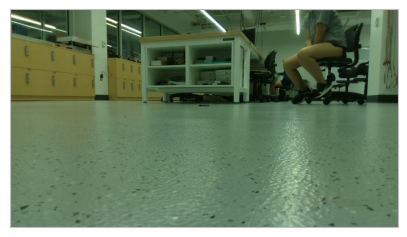

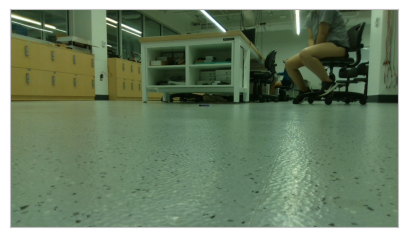

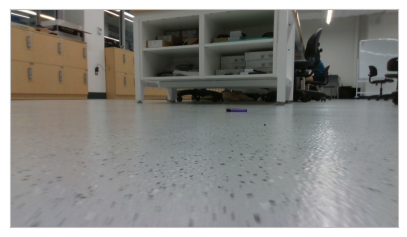

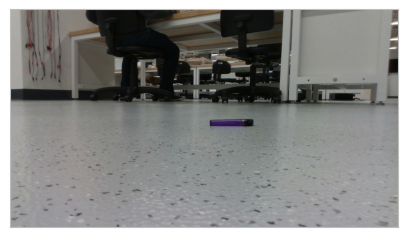

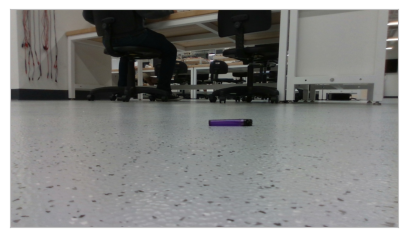

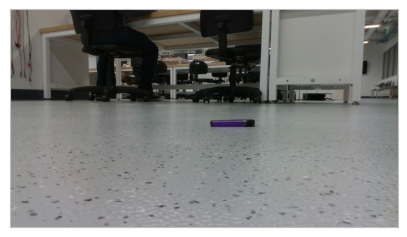

In [95]:
lighter_pic_array = Resize_Before_Training(lighter_array)


In [96]:
lighter_pic_array.shape

(250, 720, 1280, 3)

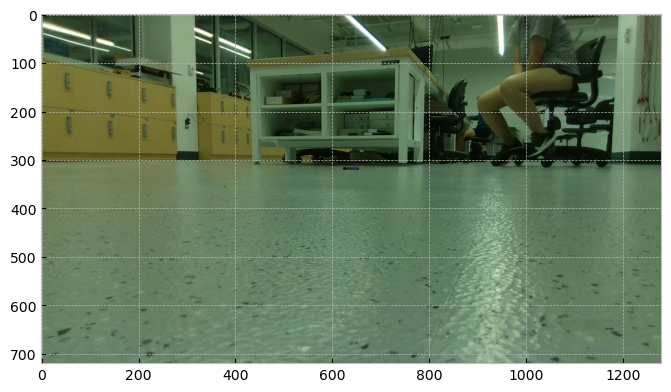

In [97]:
aPic = lighter_pic_array[0]
#aPic = single[33].reshape((720,1280,3))
plt.figure(figsize=(8,8))
plt.imshow(aPic, cmap="gray")
plt.show()

In [98]:
img_height = 720
img_width = 1280
batch_size = 32

In [224]:
data_augmentation = keras.Sequential(
  [
#     keras.layers.RandomFlip("horizontal",
#                       input_shape=(img_height,img_width,3)),
#    keras.layers.RandomContrast((0.99, 0.99))
    
  ]
)

In [225]:
# n_single = aPic # must be this size for data_aug processing to work 
# plt.figure(figsize=(8, 8))
# plt.imshow(n_single[0].astype("uint8"))
# plt.axis("off")

In [226]:
augmented_images = data_augmentation(lighter_pic_array)

In [227]:
augmented_images.shape

TensorShape([250, 720, 1280, 3])

In [234]:
augmented_contrast_images = tf.image.adjust_contrast(augmented_images, 2)
# augmented_contrast_images = augmented_images
# i = 0
# for x in augmented_images:
#     randContrast = random.uniform(0.8, 2.5)
#     augmented_contrast_images[i] = tf.image.adjust_contrast(augmented_contrast_images[i], randContrast)
#     i+=1

In [235]:
type(augmented_images)
augmented_flipped_contrast_imgs = tf.image.flip_left_right(augmented_contrast_images)
# numpyAugImg = np.array(augmented_images)
# numpyAugImg.shape

In [236]:
#original_img = Image.open("original.png")
# i = 0
# numpyAugImg[0].transpose(Image.FLIP_LEFT_RIGHT)
# for x in numpyAugImg:
# #     if i == 1:
# #         print(x.shape)
#     x = tf.image.flip_left_right(x)
#     i+=1
#vertical_img.save("vertical.png")
 
# close all our files object
#original_img.close()
#vertical_img.close()

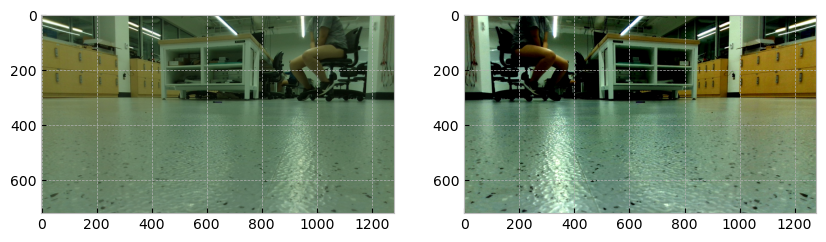

In [244]:
index = 0
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(lighter_pic_array[index], cmap = 'gray')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(augmented_flipped_contrast_imgs[index].numpy().astype("uint8"), cmap='gray')
#ax2.imshow(numpyAugImg[index], cmap='gray')
#plt.axis("off")

#plt.minorticks_off

In [243]:
i = 0
for x in augmented_flipped_contrast_imgs:
    tf.keras.utils.save_img(r"C:\Users\jorge\New_Lighter_Pics\new_pic"+str(i)+".jpg", augmented_flipped_contrast_imgs[i])
    i += 1

In [84]:
"""Constructing Regression CNN/MLP Model """
model = keras.models.Sequential([
    keras.layers.Input(shape=(img_height,img_width,3) ),
    #data_augmentation,
    keras.layers.Rescaling(1./255 ), 
    #keras.layers.Input(shape=(300,300,3) ) , 
    #keras.layers.Conv2D(4, 7, activation='relu', padding='same' , input_shape=[300, 300, 3]), 
    keras.layers.Conv2D(4, 7, activation='relu', padding='same'), # params: (filter count, kernelsize(pixel for kernel) ... ) 
    keras.layers.MaxPooling2D(2), # experiment to maybe remove
    keras.layers.Conv2D(8, 8, activation='relu', padding='same'), 
    keras.layers.MaxPooling2D(2), 
    keras.layers.Flatten(), 
    # starting MLP layer
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(4, activation='softplus'),  #4 for four coordinates, softplus to ensure positive outputs
])



SyntaxError: cannot assign to attribute here. Maybe you meant '==' instead of '='? (4247318290.py, line 9)

In [45]:
"""Compiling Classifier """
# model.compile(loss=keras.losses.mse,   #MSE or MAE for regression task?
#              optimizer=keras.optimizers.Adam(learning_rate=0.001),
#              metrics=['mean_squared_error']) # could track mae if i want here 
# model.compile(loss=keras.losses.mse,   #MSE or MAE for regression task?
#              optimizer=keras.optimizers.Adam(learning_rate=0.001),
#              metrics=[tf.keras.metrics.MeanIoU(num_classes=2)]) 

model.compile(loss=keras.losses.mse,   #MSE or MAE for regression task?
             optimizer=keras.optimizers.Adam(learning_rate=0.001)) 

In [46]:
# history = model.fit(X_train_R, t_train, epochs=100, batch_size=32,
#          validation_data=(X_test_R, t_test),
#          callbacks=[keras.callbacks.EarlyStopping(patience=5)]) # callback: 5 steps with no improvment = stop

history = model.fit(X_train_R, t_train, epochs=15, batch_size=32,
         validation_data=(X_test_R, t_test)) 

Epoch 1/15


2023-11-02 18:26:44.125491: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2023-11-02 18:26:54.163013: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


11/11 [==============================] - 19s 240ms/step - loss: 0.1436 - val_loss: 0.1378
Epoch 2/15
11/11 [==============================] - 1s 101ms/step - loss: 0.1379 - val_loss: 0.1378
Epoch 3/15
11/11 [==============================] - 1s 120ms/step - loss: 0.1379 - val_loss: 0.1378
Epoch 4/15
11/11 [==============================] - 1s 122ms/step - loss: 0.1379 - val_loss: 0.1378
Epoch 5/15
11/11 [==============================] - 2s 160ms/step - loss: 0.1379 - val_loss: 0.1378
Epoch 6/15
11/11 [==============================] - 1s 87ms/step - loss: 0.1379 - val_loss: 0.1378
Epoch 7/15
11/11 [==============================] - 1s 85ms/step - loss: 0.1379 - val_loss: 0.1378
Epoch 8/15
11/11 [==============================] - 1s 84ms/step - loss: 0.1379 - val_loss: 0.1378
Epoch 9/15
11/11 [==============================] - 1s 85ms/step - loss: 0.1379 - val_loss: 0.1378
Epoch 10/15
11/11 [==============================] - 1s 113ms/step - loss: 0.1379 - val_loss: 0.1378
Epoch 11/15
1

In [47]:
y_train = model.predict(X_train_R)
y_test = model.predict(X_test_R)

numpy.ndarray

In [29]:
y_train_converted = convert_floatMatrix_to_int(y_train, 1280)
y_test_converted = convert_floatMatrix_to_int(y_test, 1280)

In [30]:
i=0
for coord in y_train_converted:
    if i > 139 and i < 150:
        print(coord)
    if i == 150:
        break 
    i+=1
    

[677. 343. 723. 350.]
[586. 345. 678. 400.]
[667. 362. 757. 423.]
[495. 326. 597. 366.]
[594. 352. 676. 404.]
[13. 14. 13. 12.]
[7. 7. 6. 8.]
[754. 304. 850. 399.]
[15. 16. 14. 17.]
[622. 362. 759. 410.]


In [31]:
i=0
t_trainMult=t_train*1280
for coord in t_trainMult:
    if i > 139 and i < 150:
        print(coord)
    if i == 150:
        break 
    i+=1

[676. 320. 751. 348.]
[586. 342. 677. 393.]
[674. 358. 760. 397.]
[483. 328. 548. 353.]
[622. 337. 696. 393.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[742. 350. 842. 382.]
[0. 0. 0. 0.]
[610. 358. 770. 402.]


In [32]:
y_train_converted[142]

array([667., 362., 757., 423.], dtype=float32)

In [33]:
y_train_converted[142], t_trainMult[142]

(array([667., 362., 757., 423.], dtype=float32),
 array([674., 358., 760., 397.]))

In [34]:
bbox = tuple(convert_Bbox_to_int(y_train_converted[142]))
bbox

(667, 362, 757, 423)

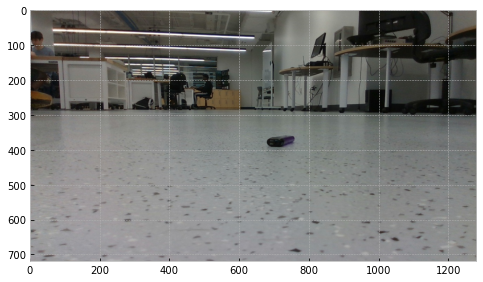

In [35]:
img_train = Image.fromarray(X_train_R[142])
#PIL_image = PIL_image.transpose(Image.ROTATE_270)
plt.figure(figsize=(8,8))
plt.imshow(img_train, cmap='gray')
#plt.xticks([]),plt.yticks([])
plt.show();

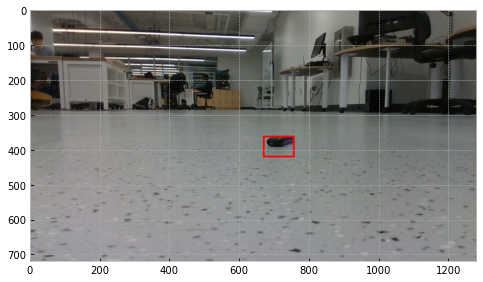

In [36]:
#bbox = tuple(floater)
img_annotated = img_train.copy()
img_bbox = ImageDraw.Draw(img_annotated)
# for coords in bbox:
#     print(coords)
# img_bbox.rectangle(bbox, outline="red", width=5)
#img_bbox.rectangle((646, 349, 743, 396), outline="red", width=5)
img_bbox.rectangle(bbox, outline="red", width=5)


plt.figure(figsize=(8,8))
plt.imshow(img_annotated, cmap='gray')
#plt.xticks([]),plt.yticks([])
plt.show();

In [37]:
y_test_converted.shape

(82, 4)

In [38]:
i=0
for coord in y_test_converted:
    if i > 49 and i < 64:
        print(coord)
    if i == 64:
        break 
    i+=1
    

[502. 338. 722. 358.]
[713. 429. 831. 481.]
[14. 15. 12. 18.]
[710. 392. 722. 417.]
[737. 380. 867. 431.]
[126.  61. 158.  80.]
[481. 407. 671. 394.]
[165. 109. 187.  97.]
[ 94.  53. 103.  60.]
[30. 31. 41. 36.]
[454. 349. 520. 264.]
[15. 20. 15. 16.]
[3. 4. 2. 3.]
[6. 7. 5. 7.]


In [39]:
i=0
t_testMult=t_test*1280
for coord in t_testMult:
    if i > 49 and i < 64:
        print(coord)
    if i == 64:
        break 
    i+=1
    

[640. 430. 917. 595.]
[741. 420. 894. 571.]
[0. 0. 0. 0.]
[622. 307. 662. 322.]
[772. 360. 888. 420.]
[750. 325. 793. 339.]
[634. 345. 791. 398.]
[ 979.  329. 1040.  363.]
[813. 336. 881. 357.]
[0. 0. 0. 0.]
[594. 360. 754. 401.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]


In [40]:
testNum = 54

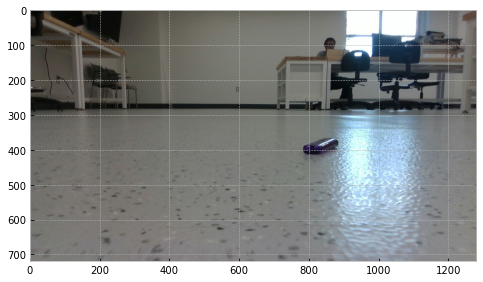

In [41]:
img_test = Image.fromarray(X_test_R[testNum])
#PIL_image = PIL_image.transpose(Image.ROTATE_270)
plt.figure(figsize=(8,8))
plt.imshow(img_test, cmap='gray')
#plt.xticks([]),plt.yticks([])
plt.show();

In [42]:
bbox_test = tuple(convert_Bbox_to_int(y_test_converted[testNum]))
bbox_test

(737, 380, 867, 431)

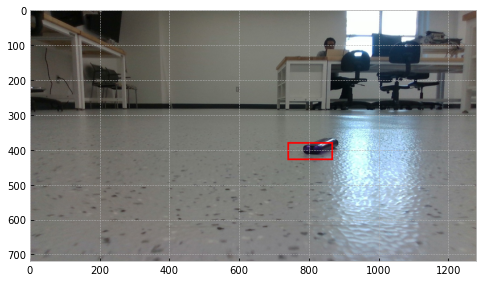

In [43]:
img_annotated = img_test.copy()
img_bbox = ImageDraw.Draw(img_annotated)
# for coords in bbox:
#     print(coords)
# img_bbox.rectangle(bbox, outline="red", width=5)
#img_bbox.rectangle((646, 349, 743, 396), outline="red", width=5)
img_bbox.rectangle(bbox_test, outline="red", width=5)


plt.figure(figsize=(8,8))
plt.imshow(img_annotated, cmap='gray')
#plt.xticks([]),plt.yticks([])
plt.show();

In [139]:
type(img_test)

PIL.Image.Image

In [42]:
one = np.array(img_test)
one.shape

(720, 1280, 3)

In [44]:
#directory = lighter_pics_HP + "/173.JPG"
directory = 'ExperimentPicsCollection/rosPics/FULL_lighter_pics/173.jpg'

In [60]:
two = cv2.imread(directory)
type(one)

numpy.ndarray

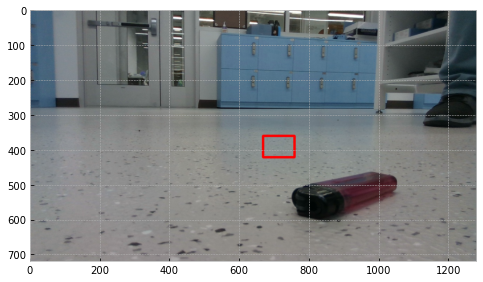

In [61]:
"""THIS IS THE CORRECT WAY TO DO IT"""

plt.figure(figsize=(8,8))
cv2.rectangle(two, (bbox[0], bbox[1]), (bbox[2], bbox[3]),(255,0,0), 5) 
#cv2.rectangle(one, (775, 450), (1100, 600),(255,0,0), 5)
plt.imshow(two, cmap='gray')
plt.show();

In [54]:
bbox

(667, 362, 757, 423)

In [55]:
single = y_train[6]
single

array([0., 0., 0., 0.], dtype=float32)

In [57]:
y_test

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],


In [ ]:
PIL_image = Image.fromarray(np.uint8(one[0])).convert('RGB')
PIL_image = PIL_image.transpose(Image.ROTATE_270)
plt.figure(figsize=(5,5))
plt.imshow(PIL_image, cmap='gray')
plt.xticks([]),plt.yticks([])
plt.show();

In [137]:
import tensorflow_model_optimization as tfmot

ModuleNotFoundError: No module named 'tensorflow_model_optimization'

In [138]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 720, 1280, 3)      0         
                                                                 
 conv2d (Conv2D)             (None, 720, 1280, 4)      592       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 360, 640, 4)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 360, 640, 8)       2056      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 180, 320, 8)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 460800)            0

In [40]:
"""Storing Model in Keras format"""
model.save('finalModel1_a.keras')

In [ ]:
"""Storing Model in SavedModel format"""
!mkdir -p saved_model
model.save('saved_model/my_model')

In [ ]:
"""Notes/Testing cells below"""

In [ ]:
#Testing: this is what Resize_Before_Training() will do 
gatr = np.ones((1,300,300,3))
gatr2 = 2*np.ones((1,300,300,3))
#gatr = gatr[np.newaxis, :]
gatrs = np.vstack((gatr,gatr2))
gatrs.shape


In [ ]:
floater = y_train[33]*1280
floater

In [ ]:
converted = convert_Bbox_to_int(floater)
converted

In [ ]:
rounded_int_list = [int(round(x)) for x in floater]
array_int = np.array(rounded_int_list, dtype='int')
array_int

In [22]:
testing = tuple((5, 6, 3, 2))
#testing = [5,6,3,2]
if testing[0] < 6 and testing[1] < 7:
    print("good")
else:
    print ("bad")
    

good


In [23]:
testing[5]

IndexError: tuple index out of range

In [18]:
testing = np.array(testing)

In [19]:
for (x, y, w, h) in testing:
    print(x)
    print(y)
    print(w)
    print(h)

TypeError: cannot unpack non-iterable numpy.int64 object

In [20]:
test = str(testing)
test

'[5 6 3 2]'

In [ ]:
testing[]